In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [154]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)  # width, height in inches

# Set default font sizes
plt.rcParams['font.size'] = 15  # Default font size
plt.rcParams['axes.titlesize'] = 15  # Title font size
plt.rcParams['axes.labelsize'] = 15  # Label font size
plt.rcParams['xtick.labelsize'] = 15  # x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_splitter_switch'
figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_splitter_switch/supp'
misc.get_or_create_subdir(figdir)
misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/figure_splitter_switch made!
/mnt/home/szheng/ceph/place_variability/fig/paper/figure_splitter_switch/supp made!


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 

var_res_all_test['fit_var_ratio_1cp'] = pval_all[1]['exp_var_ratio']
var_res_all_test['fit_var_ratio_div_sh_1cp'] = pval_all[1]['exp_var_ratio'] / pval_all[1]['exp_var_ratio_sh_med']

In [6]:
import variability_axis as va
reload(va)

<module 'variability_axis' from '/mnt/home/szheng/projects/place_variability/code/variability_axis.py'>

In [22]:
all_fields_sub = all_fields_recombined_all.loc[(slice(None),slice(None),0,[0,1]),:]
all_fields_splitter = all_fields_sub.loc[all_fields_sub['end'] <= 33]

In [24]:
all_fields_splitter_ind = all_fields_splitter.index
best_n_splitter=best_n_all_test.loc[all_fields_splitter_ind]
has_sw_splitter = best_n_splitter > 0

In [34]:
has_sw_splitter_ind = has_sw_splitter.loc[has_sw_splitter].index

0      5.322901
1      6.102473
2      5.880827
3     12.917630
4      5.711104
5      3.539069
6      2.418798
7      0.758023
8      0.004824
9      3.011283
10     3.118588
11     0.870035
12     6.282773
13     5.089133
14     0.004806
15     5.155842
16     1.699722
17     3.665837
18     0.492327
19     1.803083
20     0.049978
21     0.047654
22     0.000000
23     2.740211
24     0.089485
25     0.391614
26     2.103740
27     6.864719
28     0.004452
29     9.585736
30     3.436679
31     2.096003
32     0.129176
33     0.253954
34     0.560087
35    10.624319
36     3.974708
dtype: float64

In [114]:
iloc_l=np.array([4,5,6,7,8,10,11,12,13,34,35,53,63,67,72])

In [153]:
ind

('e13_26m1', 'e13_26m1_211119', 0, 0.0, 145, 0)

/tmp/ipykernel_91626/177667586.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  vmax = fr_map_trial_df_all.loc[(ani,sess,ti),:].unstack(level=0).loc[uid].loc[field_bound[0]:field_bound[1],:].max().max()
/tmp/ipykernel_91626/177667586.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_ind,uid),:].dropna(axis=1).T
/tmp/ipykernel_91626/177667586.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  vmax = fr_map_trial_df_all.loc[(ani,sess,ti),:].unstack(level=0).loc[uid].loc[field_bound[0]:field_bound[1],:].max().max()
/tmp/ipykernel_91626/177667586.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_ind,uid),:].dropna(axis=1).T
/tmp/ipykernel_91626/177667586.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  vmax = fr_map_trial_df

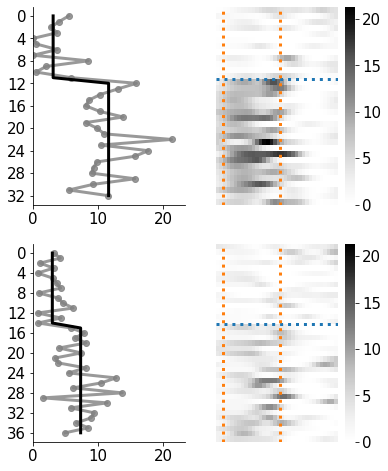

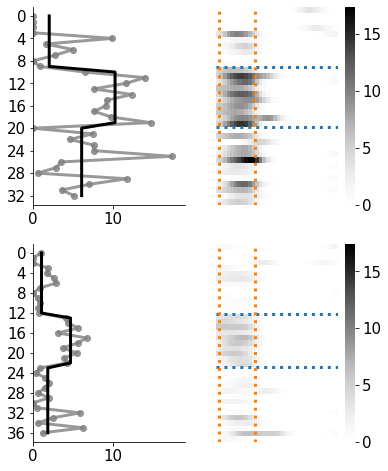

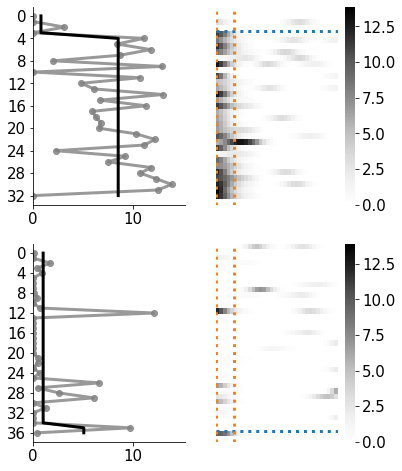

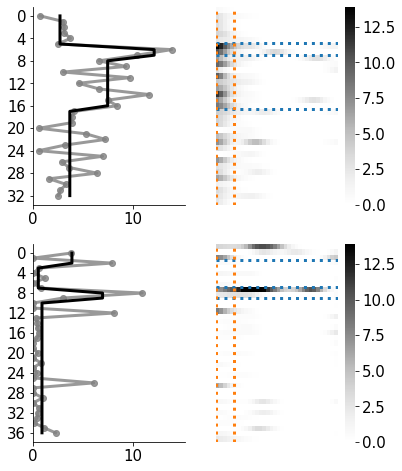

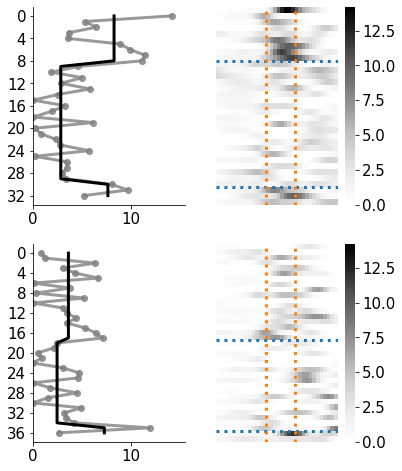

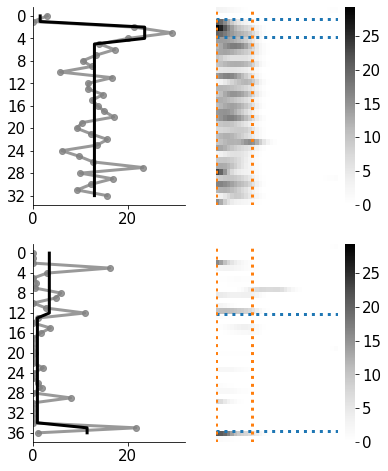

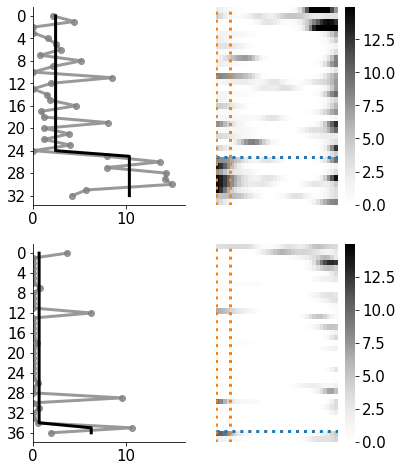

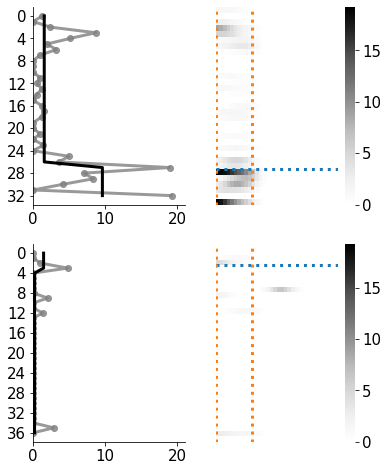

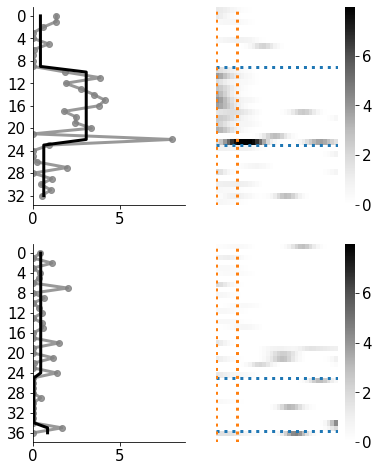

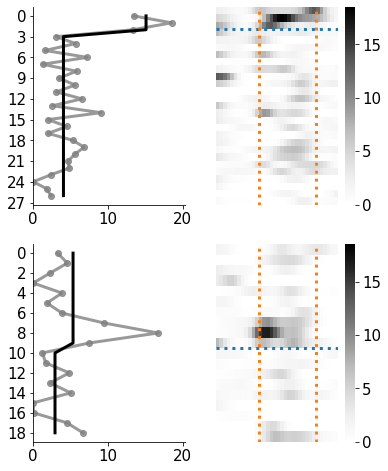

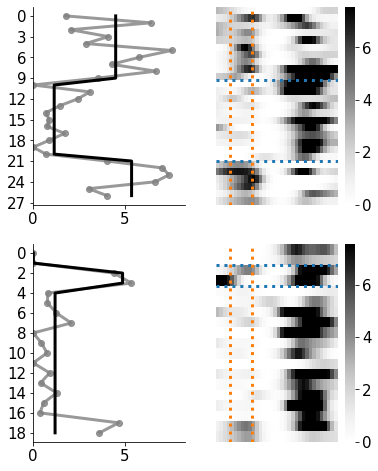

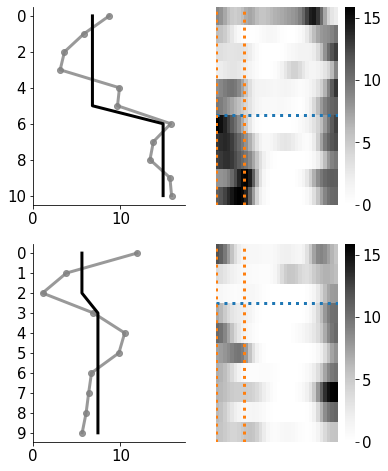

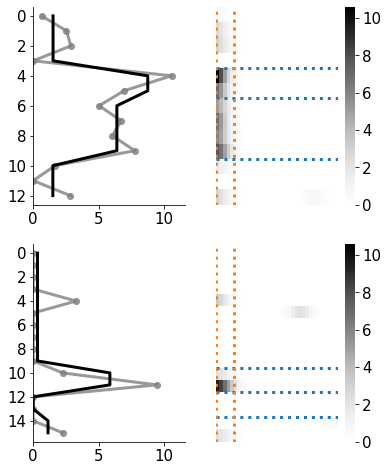

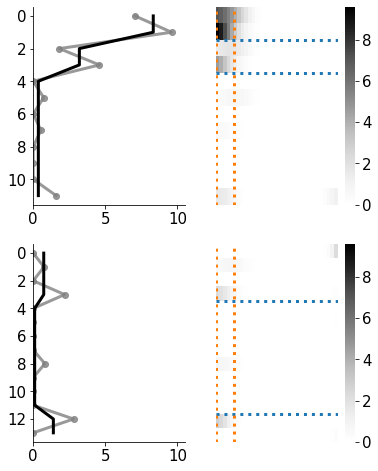

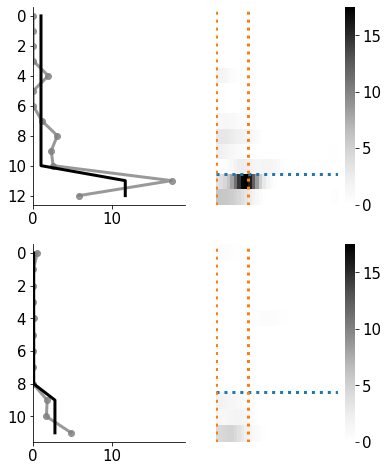

In [156]:
# iloc_selected = np.arange(72,84)
iloc_selected=iloc_l
central_arm_end_lin_binned = 33
has_sw_splitter_ind_sub = has_sw_splitter_ind[iloc_selected]
for ii, ind in enumerate(has_sw_splitter_ind_sub):
    fig,ax=None,None
    ani,sess,ti,tt,uid,field_id = ind
    tt_rm = tt
    
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
    fig,axs = plt.subplots(2,2,figsize=(6,8))
    vmax = fr_map_trial_df_all.loc[(ani,sess,ti),:].unstack(level=0).loc[uid].loc[field_bound[0]:field_bound[1],:].max().max()
    for jj,tt_ind in enumerate([0,1]):
#         ax=axs[jj]
        fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_ind,uid),:].dropna(axis=1).T
        fr_map_trial_one = fr_map_trial_one.loc[:,0:central_arm_end_lin_binned]
    
        signal = fr_map_trial_one.loc[:,field_bound[0]:field_bound[1]].max(axis=1).values
        ncpt=best_n_all_test.loc[ani,sess,ti,tt,uid,field_id]
        ax=axs[jj,0]
        fig,ax,pwc,change_trial_within=cpa.predict_from_cpts_wrapper_plot(signal,ncpt,cost='l2',min_size=2,fig=fig,ax=ax)
        ax.set(xlim=[0,vmax*1.1])

        ax=axs[jj,1]
        
        ph.ratemap_one_raw(fr_map_trial_one,trial=change_trial_within,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={"vmax":vmax})
#         ax.set_title(iloc_selected[ii])
        ax.set(xticks=[],yticks=[])
    fig.savefig(os.path.join(figdir,f'splitter_sw_ex_{ind}.svg'),bbox_inches='tight')
    

In [143]:
spk_beh_df_one = spk_beh_df_all.loc[(ani,sess),:]

index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_one)

/tmp/ipykernel_91626/1383788167.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df_one = spk_beh_df_all.loc[(ani,sess),:]


In [145]:
trial_offset=index_within_to_trial_index_df.loc[ti,0].values[:,None] - index_within_to_trial_index_df.loc[ti,1].values[:,None].T
closest_inds = np.argsort(np.abs(trial_offset),axis=1)[:,:2]


fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,0,uid),:].dropna(axis=1).T
fr_map_trial_one = fr_map_trial_one.loc[:,0:central_arm_end_lin_binned]
signal1 = fr_map_trial_one.loc[:,field_bound[0]:field_bound[1]].max(axis=1).values

fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,1,uid),:].dropna(axis=1).T
fr_map_trial_one = fr_map_trial_one.loc[:,0:central_arm_end_lin_binned]
signal2 = fr_map_trial_one.loc[:,field_bound[0]:field_bound[1]].max(axis=1).values



/tmp/ipykernel_91626/528637647.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,0,uid),:].dropna(axis=1).T
/tmp/ipykernel_91626/528637647.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,1,uid),:].dropna(axis=1).T


In [148]:
signal2

array([0.52489807, 0.        , 0.        , 0.        , 0.0591413 ,
       0.        , 0.        , 0.        , 0.        , 1.77086005,
       1.67326166, 4.81193285])

In [152]:
np.min(signal1[:,None] - signal2[closest_inds],axis=1)

array([-0.52489807,  0.        ,  0.        , -0.0591413 ,  1.91211428,
        0.        ,  0.        ,  1.09454648,  1.27847957,  0.51189789,
        0.74719116, 15.74181228,  0.9809903 ])

In [47]:
spk_beh_df_one = spk_beh_df_all.loc[(ani,sess),:]

index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_one)

/tmp/ipykernel_91626/2188717358.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df_one = spk_beh_df_all.loc[(ani,sess),:]


In [51]:
data1 = fr_map_trial_df_all.loc[(ani,sess,ti,0,uid),:].dropna(axis=1).T
data2 = fr_map_trial_df_all.loc[(ani,sess,ti,1,uid),:].dropna(axis=1).T

/tmp/ipykernel_91626/105925710.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  data1 = fr_map_trial_df_all.loc[(ani,sess,ti,0,uid),:].dropna(axis=1).T
/tmp/ipykernel_91626/105925710.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data2 = fr_map_trial_df_all.loc[(ani,sess,ti,1,uid),:].dropna(axis=1).T


In [52]:
data = pd.concat([data1,data2],axis=0)

In [56]:
import matplotlib.colors as mcolors


norm = mcolors.Normalize(vmin=data.min().min(), vmax=data.max().max())
data1 = norm(data1)
data2 = norm(data2)

# Apply colormaps
data1_colored = plt.cm.Blues(data1)
data2_colored = plt.cm.Reds(data2)


In [59]:
ntrials = index_within_to_trial_index_df.loc[ti].shape[0]
npos = data1.shape[1]
data_colored = np.zeros((ntrials,npos,4))
data_colored[index_within_to_trial_index_df.loc[ti,0],:,:]=data1_colored
data_colored[index_within_to_trial_index_df.loc[ti,1],:,:]=data2_colored

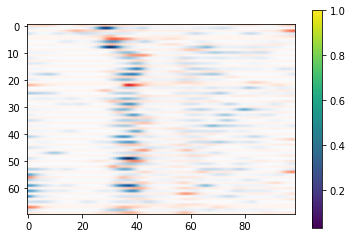

In [62]:
plt.imshow(data_colored)
plt.colorbar()
plt.show()

/tmp/ipykernel_91626/2188717358.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df_one = spk_beh_df_all.loc[(ani,sess),:]


In [44]:
spk_beh_df_one

,1,2,3,4,5,6,7,8,9,10,...,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed,lin_binned,direction,v_raw
220,0,0,0,3,5,2,3,2,1,4,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
221,0,0,0,3,2,2,2,1,0,0,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
222,0,0,0,2,4,4,2,1,0,1,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
223,0,0,0,2,3,3,1,0,0,0,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
224,0,0,0,1,2,3,1,1,1,0,...,4.816185,True,False,True,False,False,False,99,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64791,0,0,0,1,2,2,1,3,1,1,...,10.068745,True,False,False,False,True,False,97,NaN,NaN
64792,0,0,0,2,3,2,2,2,1,0,...,9.724899,True,False,False,False,True,False,97,NaN,NaN
64793,0,0,0,2,1,0,1,4,0,3,...,9.400999,True,False,False,False,True,False,96,NaN,NaN
64794,0,0,0,2,3,0,2,2,1,2,...,9.185424,True,False,False,False,True,False,96,NaN,NaN


In [ ]:
ani

In [37]:
has_sw_splitter_ind_sub

MultiIndex([('e13_26m1', 'e13_26m1_210913', 0, 0.0,  29, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0,  36, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0,  37, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0,  57, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0,  83, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 121, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 136, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 162, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 182, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 198, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 232, 0),
            ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 237, 0)],
           )

In [28]:
has_sw_splitter_ind

e13_26m1  e13_26m1_210913  0  0.0  29  0    True
                                   36  0    True
                                   37  0    True
                                   57  0    True
                                   83  0    True
                                            ... 
e15_9f1   e15_9f1_200720   0  1.0  29  0    True
          e15_9f1_200715   0  1.0  39  0    True
e14_2m3   e14_2m3_201121   0  1.0  9   0    True
                                   43  0    True
          e14_2m3_201118   0  1.0  2   0    True
Length: 224, dtype: bool

In [26]:
has_sw_splitter

e13_26m1  e13_26m1_210913  0  0.0  27  0    False
                                   29  0     True
                                   30  0    False
                                   34  0    False
                                   36  0     True
                                            ...  
e14_2m3   e14_2m3_201118   0  1.0  5   0    False
                                   17  0    False
                                   20  0    False
                                   25  0    False
                                   33  0    False
Length: 1528, dtype: bool